In [51]:
import pandas as pd
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models 



In [52]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
])


In [53]:
train_dataset = datasets.ImageFolder(root='/Users/ashu/Downloads/flower_comparison/V2/Training Data', transform=transform)
test_dataset = datasets.ImageFolder(root='/Users/ashu/Downloads/flower_comparison/V2/Testing Data', transform=transform)
val_dataset = datasets.ImageFolder(root='/Users/ashu/Downloads/flower_comparison/V2/Validation Data', transform=transform)

In [54]:
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [55]:

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV2, self).__init__()
        self.features = models.mobilenet_v2(pretrained=False).features
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x


In [56]:

device = "mps"

In [57]:
class_names=train_dataset.classes
print(class_names)
print(len(class_names))

['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']
10


In [58]:
model = MobileNetV2(num_classes = len(class_names)).to(device)


In [59]:
torch.device("mps")
best_checkpoint = torch.load('/Users/ashu/Downloads/flower_comparison/d2_mnv2_model_checkpoint.pth',map_location=torch.device('mps'))
print(best_checkpoint.keys())
model.load_state_dict(best_checkpoint['state_dict'])


dict_keys(['epoch', 'state_dict', 'optimizer', 'train_loss', 'val_loss'])


<All keys matched successfully>

In [60]:
# Extract the features for each batch of images
features = []
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [61]:
with torch.no_grad():
    for images, _ in train_dataloader:
        images = images.to('mps')
        feats = model(images)
        features.append(feats.cpu().detach().numpy())



In [62]:
# Convert the features to a 2D array using t-SNE
features = np.concatenate(features, axis=0)
tsne = TSNE(n_components=3, perplexity=50, learning_rate=200, random_state=123)
embeddings = tsne.fit_transform(features)

In [63]:
unique_targets = torch.unique(torch.tensor(train_dataset.targets))
print("Unique targets:", unique_targets)

Unique targets: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


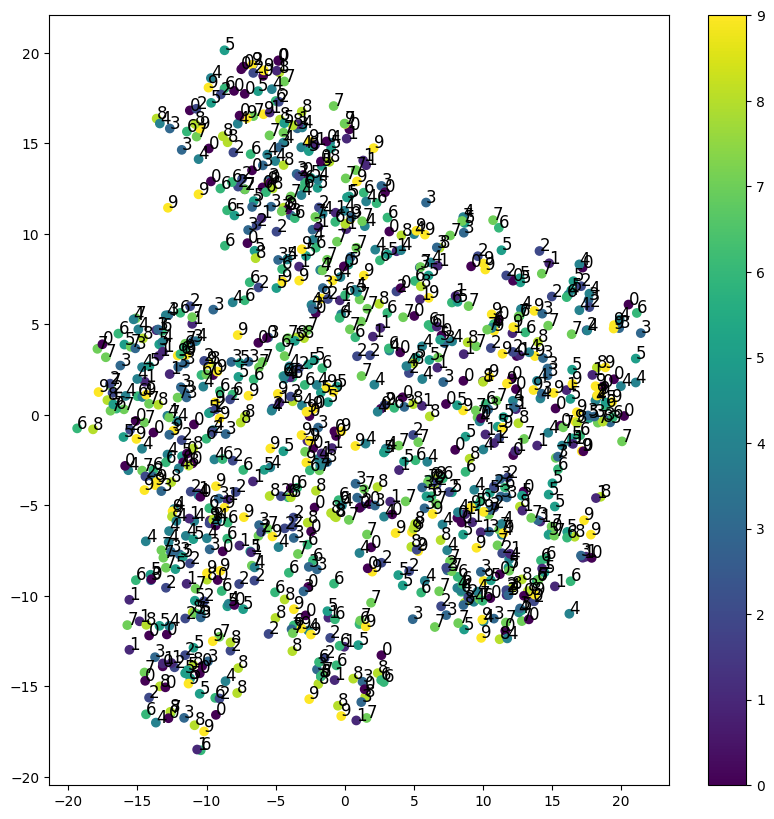

In [64]:
import numpy as np

# randomly select 1000 embeddings
indices = np.random.choice(len(embeddings), size=1000, replace=False)
subset_embeddings = embeddings[indices]
subset_targets = np.array(train_dataset.targets)[indices]

# plot the subset of embeddings
plt.figure(figsize=(10, 10))
plt.scatter(subset_embeddings[:, 0], subset_embeddings[:, 1], c=subset_targets, cmap='viridis')
for i, txt in enumerate(subset_targets):
    plt.text(subset_embeddings[i, 0], subset_embeddings[i, 1], str(txt), fontsize=12)
plt.colorbar()
plt.show()


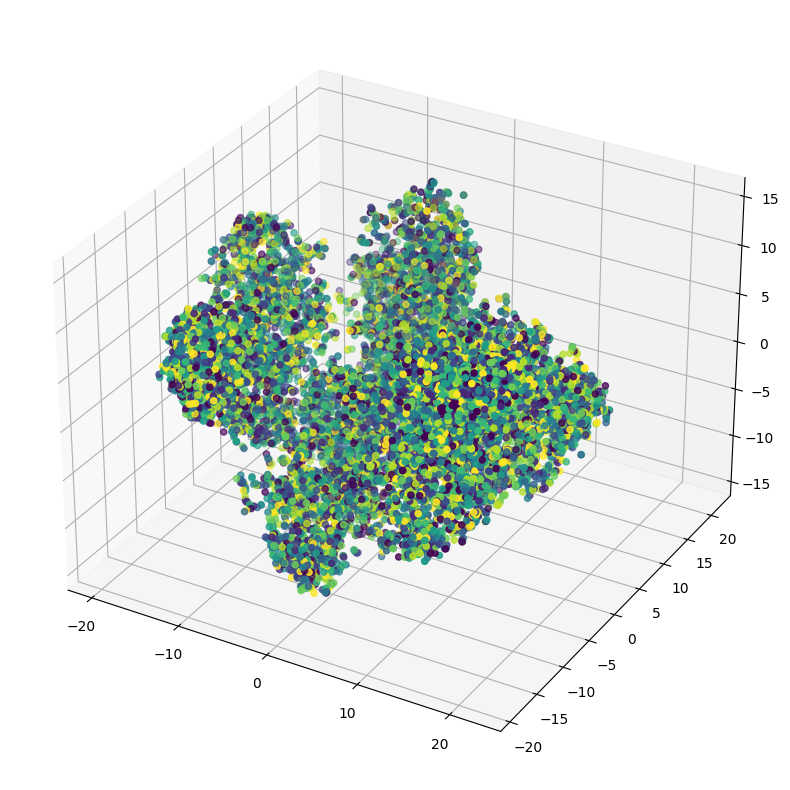

In [65]:
# Plot the embeddings
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=train_dataset.targets)
plt.show()


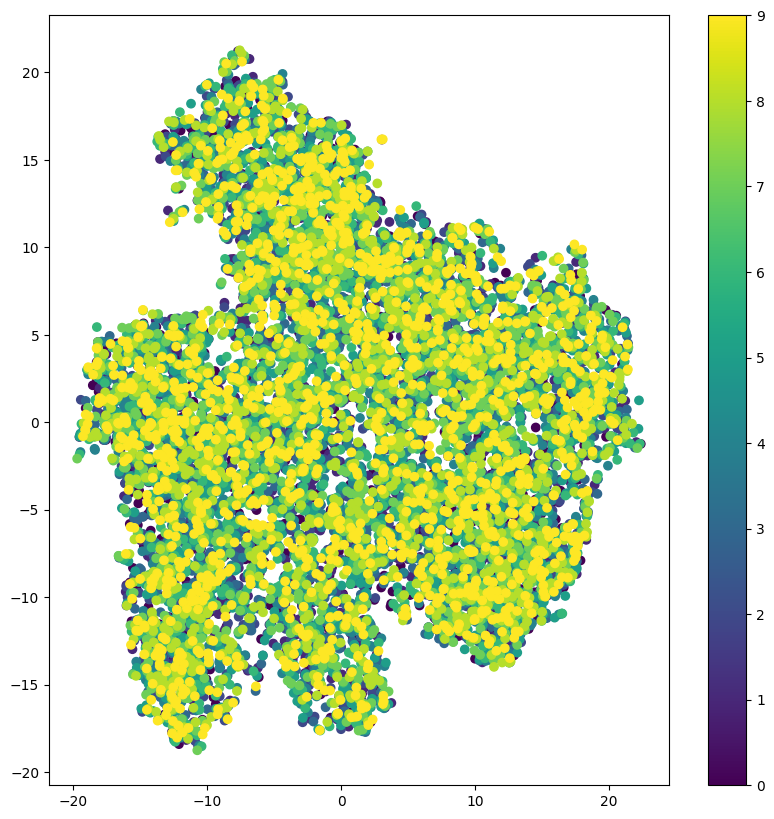

In [66]:
# Plot the embeddings
plt.figure(figsize=(10, 10))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=train_dataset.targets, cmap='viridis')
plt.colorbar()
plt.show()

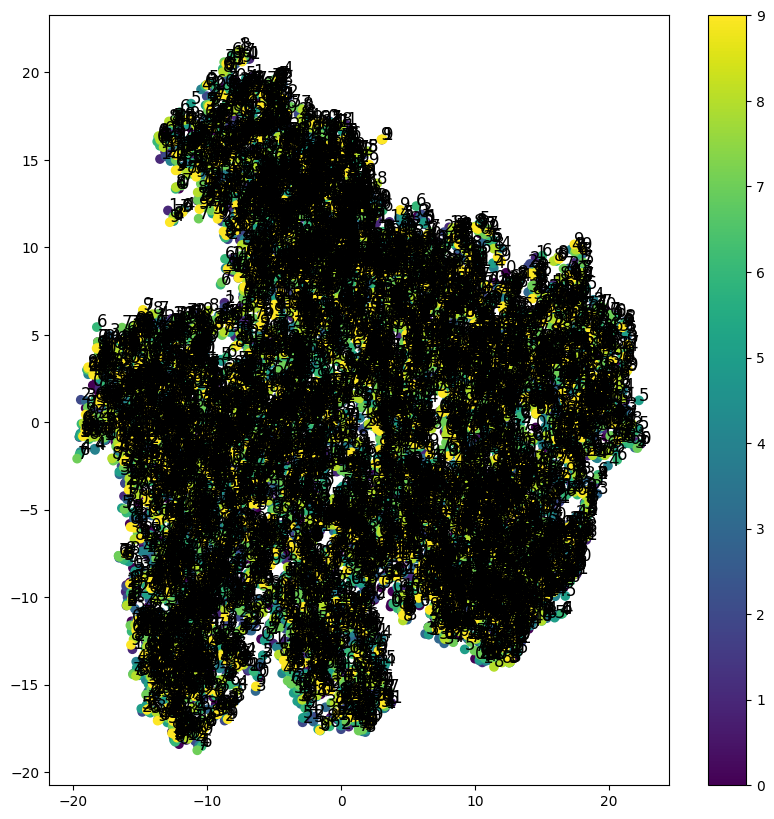

In [67]:
# Plot the embeddings
plt.figure(figsize=(10, 10))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=train_dataset.targets, cmap='viridis')

# Add text labels for each point
for i, txt in enumerate(train_dataset.targets):
    plt.text(embeddings[i, 0], embeddings[i, 1], str(txt), fontsize=12)

plt.colorbar()
plt.show()


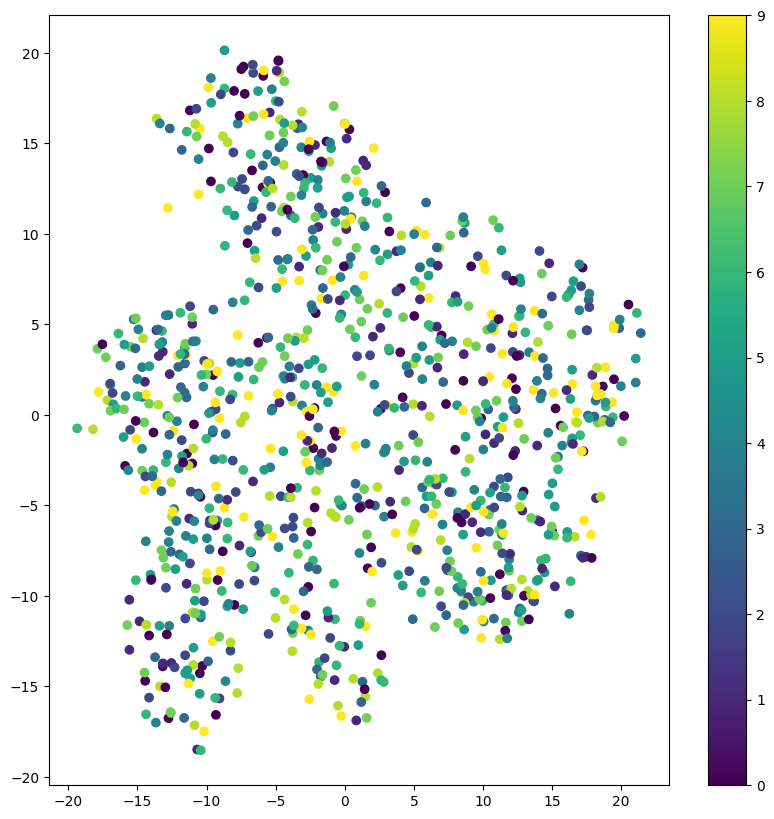

In [68]:
import numpy as np

# Select a random subset of embeddings to plot
N =  1000   # Number of points to plot
indices = np.random.choice(indices, size=N, replace=False)

subset_embeddings = embeddings[indices]
subset_targets = []

for idx in indices:
    subset_targets.append(train_dataset.targets[idx])

# Plot the embeddings with targets as labels
plt.figure(figsize=(10, 10))
plt.scatter(subset_embeddings[:, 0], subset_embeddings[:, 1], c=subset_targets, cmap='viridis')
plt.colorbar()
plt.show()
